# ORTHOGONAL POLYNOMIAL DENSITY ESTIMATION
## Preliminaries
### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
from uuid import uuid4

from lpde.geometry import WidthOf, Window, PointAt, BoundingBox, Mapper
from lpde.estimator import SerialEstimator
from lpde.estimator.datatypes import Event, Degree, Action, Scalings

### Notebook settings

In [2]:
%matplotlib notebook

## Density Estimation
### Initialize

In [3]:
legendre_width = WidthOf(1.8)

center = PointAt(0, 0)
window = Window(1.8, 1.8)
bounds = BoundingBox(center, window)

mapper = Mapper(bounds, legendre_width)

degree = Degree(20, 20)
density = SerialEstimate(degree, mapper)

action = Action.ADD
point = PointAt(0.5, 0.5)
event = Event(uuid4(), action, point)

### Create mock data streams

In [4]:
def gaussian():
    x, y = np.random.multivariate_normal((0,0), ((0.1,0), (0,0.1)))
    if (-0.9 <= x <= 0.9) and (-0.9 <= y <= 0.9):
        return x, y
    else:
        return gaussian()

def uniform():
    return np.random.uniform(low=-0.9, high=0.9, size=2)

locations = []

def new_event(dist):
    location = dist()
    locations.append(location)
    point = PointAt(*location)
    return Event(uuid4(), Action(1), point)

def random_event(dist):
    event_type = np.random.randint(low=-1, high=2)
    if event_type == 1:
        location = dist()
        point = PointAt(*location)
        return Event(uuid4(), Action(1), point)
    elif event_type == 0:
        location = dist()
        point = PointAt(*location)
        column = density._phi.sample(1, axis=1).columns.values[0]
        return Event(column, Action(0), point)
    column = density._phi.sample(1, axis=1).columns.values[0]
    return Event(column, Action(-1))

### Timings of density estimation

In [5]:
%%time
for i in range(1000):
    density.update_with(new_event(gaussian))

/Users/georg/Documents/Python/LPDE/lpde/estimator/serial/serial.py:90: RuntimeWarning: overflow encountered in double_scalars
  return self.__neg_log_l(c[1:]) + c[0]*self.__norm(c[1:])


CPU times: user 1min 10s, sys: 6.03 s, total: 1min 16s
Wall time: 46.9 s


In [ ]:
%%time
for i in range(1000):
    density.update_with(random_event(gaussian))

In [ ]:
%%time
for i in range(1000):
    density.at(new_event(uniform).location)

__Timings__

33 ms per additive update with uniform distribution

31 ms per random update with uniform distribution

0.6 ms per evaluation at point

### Plot final density

<IPython.core.display.Javascript object>


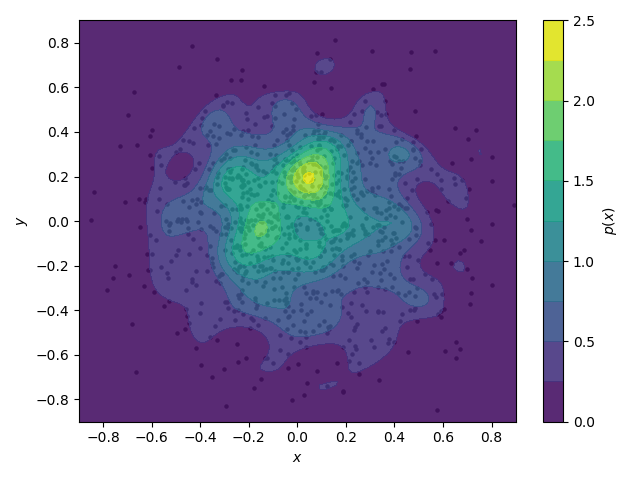

In [6]:
x_grid = np.linspace(-0.9, 0.90, 100)
y_grid = np.linspace(-0.9, 0.90, 100)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)

p_hat = density._on(x_grid, y_grid)

fig, ax = plt.subplots()
ax.set(xlabel=r'$x$', ylabel=r'$y$')
ax.scatter(*zip(*locations), s=5, c='k')
contour = ax.contourf(x_grid, y_grid, p_hat, 9, cmap='viridis', alpha=0.9)
cbar = plt.colorbar(contour, ax=ax, label=r'$p(x)$')
fig.tight_layout()

## Coefficient smoothing

In [5]:
coeffs = []

for i in range(1000):
    density.update_with(new_event(gaussian))
    coeffs.append(density._c.tolist())  

coeffs = np.array(coeffs).T

/Users/georg/Documents/Python/LPDE/lpde/estimator/serial.py:90: RuntimeWarning: overflow encountered in double_scalars
  return self.__neg_log_l(c[1:]) + c[0]*self.__norm(c[1:])
/Users/georg/Documents/Python/LPDE/lpde/estimator/serial.py:98: RuntimeWarning: overflow encountered in square
  return -log(square(c.dot(self.__phi_ijn.values))).sum()
/Users/georg/Documents/Python/LPDE/lpde/estimator/serial.py:94: RuntimeWarning: overflow encountered in multiply
  self.__grad_c[1:] = self.__grad_neg_log_l(c[1:]) + 2.0*c[0]*c[1:]


<IPython.core.display.Javascript object>


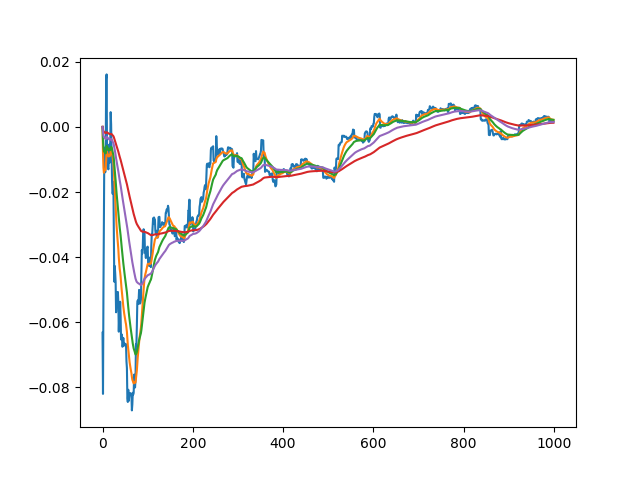

In [16]:
ij = 1

fig, ax = plt.subplots()
ax.plot(coeffs[ij])

In [17]:
def filtered(x, a):
    result = np.zeros_like(x)
    for i in range(1, len(x)):
        result[i] = a*x[i] + (1-a)*result[i-1]
    return result

<IPython.core.display.Javascript object>


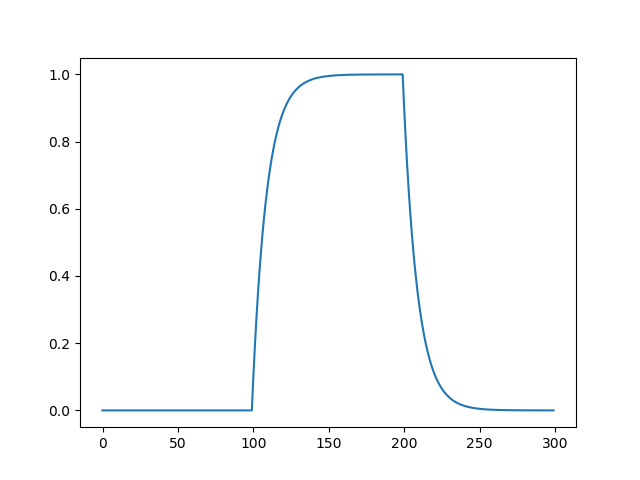

In [31]:
fig, ax = plt.subplots()
ax.plot(filtered(test, 0.1))

In [30]:
test = np.ones(100)
test = np.append(np.zeros(100), test)
test = np.append(test, np.zeros(100))

In [ ]:
import scipy.signal as scps

In [ ]:
b, a = scps.butter(2, 0.03)
plt.plot(scps.lfilter(b, a, coeffs[ij]))

In [ ]:
b